In [1]:
# Import libraries
from fastai.vision.all import *
from duckduckgo_search import DDGS
from fastdownload import download_url

In [2]:
# Check MPS availability
torch.backends.mps.is_available()

True

# Data

In [3]:
# Search black, brown, and teddy bear images
im_url = L(DDGS().images('black bear',max_results=1)).itemgot('image')
im_url

(#1) ['https://cdn.britannica.com/18/235818-050-9246E9F3/American-black-bear-ursus-americanus-close-up.jpg']

In [4]:
im = download_url(im_url[0],'data/bear.jpg')

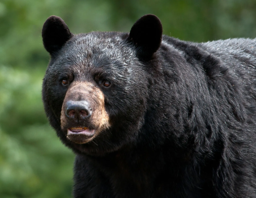

In [5]:
im = Image.open('data/bear.jpg')
im.to_thumb(256,256)

In [6]:
def search_images(term, max_results=150): 
    return L(DDGS().images(term,max_results=max_results)).itemgot('image')

In [7]:
# Define 
searches = ['black','brown','teddy']
path = Path('data/bears')

In [10]:
# Donwload all bear images
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bear photo'))
    resize_images(path/o, max_size=400, dest=path/o)

In [8]:
# Get files paths
fns = get_image_files(path)
fns

(#355) [Path('data/bears/brown/98a30599-1fa7-4420-ac14-792ad6257219.jpg'),Path('data/bears/brown/0ff7ed66-9724-4b6b-ba25-b61e54aff9b1.jpg'),Path('data/bears/brown/634e8801-e149-44f1-a0f1-ad6062d0306f.jpg'),Path('data/bears/brown/4bb88a77-8955-4afc-ad1a-c1be39c224f0.jpg'),Path('data/bears/brown/b7c48a21-163a-4d38-bd32-464de2750c8d.jpg'),Path('data/bears/brown/26a00f4d-6aa2-4c92-884e-80559c5e1ce4.jpg'),Path('data/bears/brown/f2fc9d28-7cb5-4a05-a7d1-ce2551a7da7f.jpg'),Path('data/bears/brown/f0999785-77c3-4420-bc1b-653b190bd833.jpg'),Path('data/bears/brown/8ca9cfeb-a306-4d25-b8f0-2ab510899ac7.jpg'),Path('data/bears/brown/20b0d61e-cf60-4293-86ff-557f1d376ea2.jpg')...]

In [9]:
# Verify which images failed
failed = verify_images(fns)
failed

(#0) []

In [10]:
# Remove failed images
failed.map(Path.unlink)

(#0) []

## Dataloaders

In [14]:
# Create the data loader 
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=parent_label,
    item_tfms=Resize(255)
)
dls = bears.dataloaders(path)

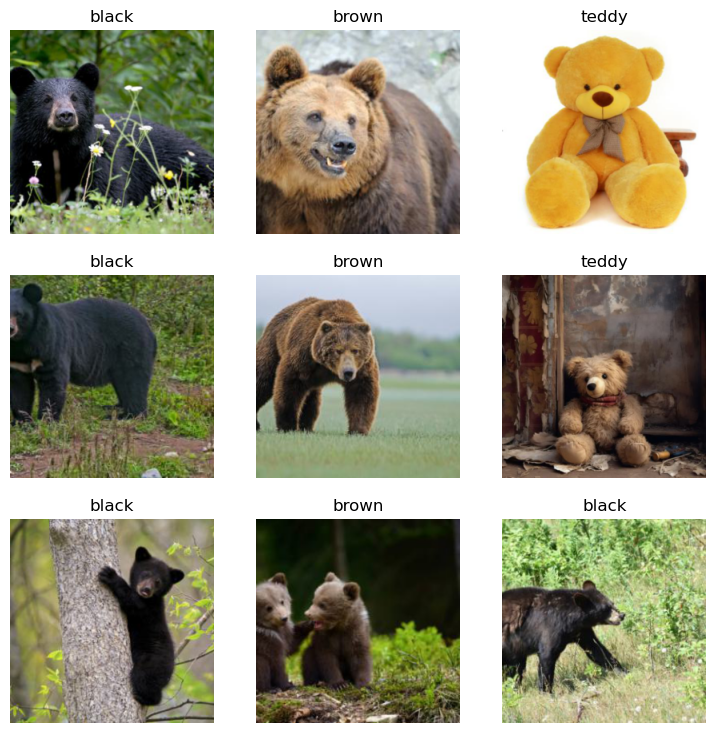

In [15]:
dls.train.show_batch()

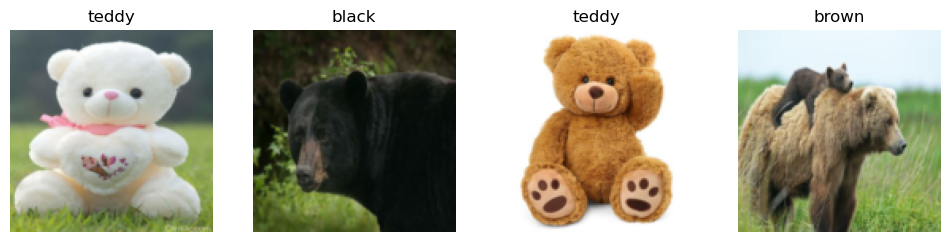

In [16]:
# Squishing the images
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)

dls.train.show_batch(max_n=4, nrows=1)

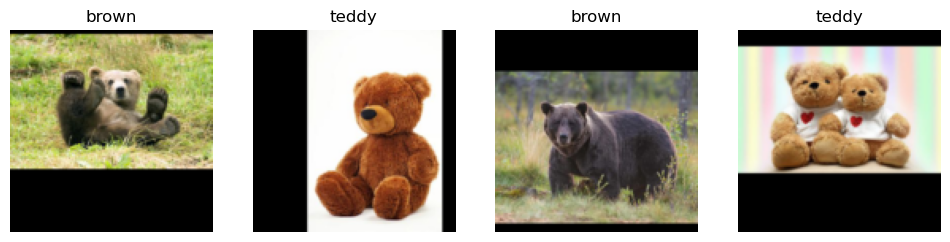

In [17]:
# Padding the images
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)

dls.train.show_batch(max_n=4, nrows=1)

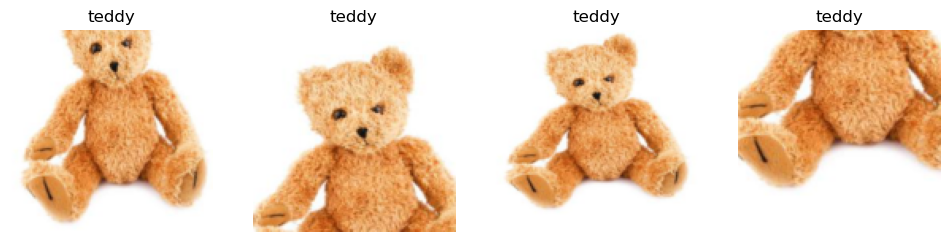

In [18]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data augmentation

In [20]:
default_device(use=0)

device(type='cpu')

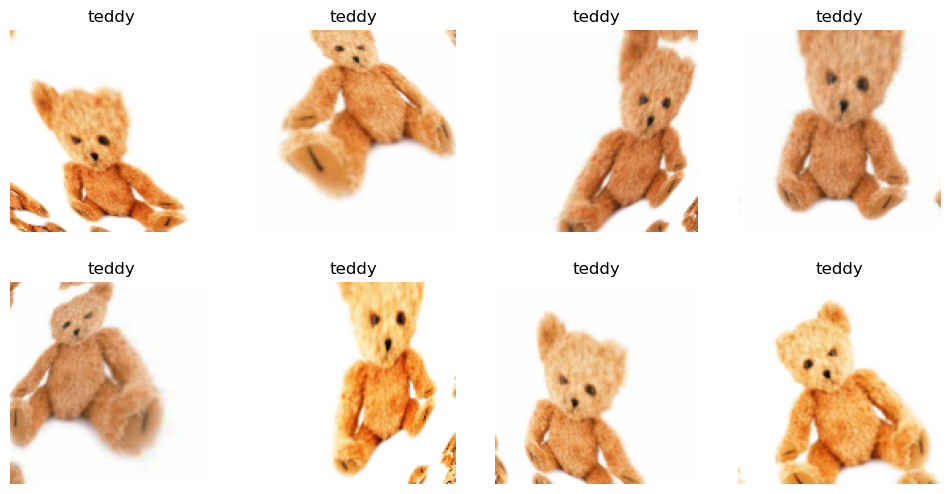

In [21]:
# Augmenting the data for training
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)

dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Cleaning data

In [32]:
# Create a dataloader
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [30]:
default_device(use=0)

device(type='cpu')

In [34]:
# Train quickly to use to clean data
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.405579,0.162951,0.070423,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.274498,0.168411,0.056338,00:11
1,0.211728,0.316673,0.070423,00:11
2,0.156470,0.387068,0.070423,00:10
3,0.128585,0.393788,0.070423,00:10


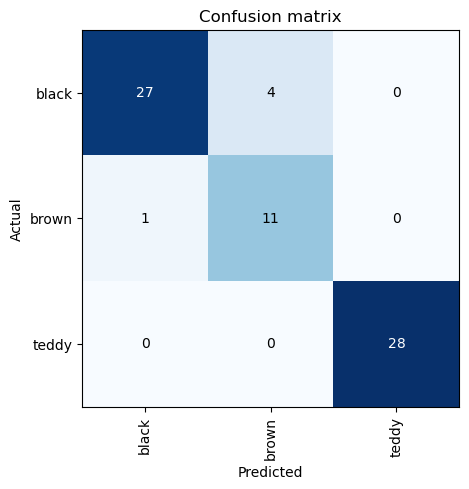

In [35]:
# Checking the classifications through a confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

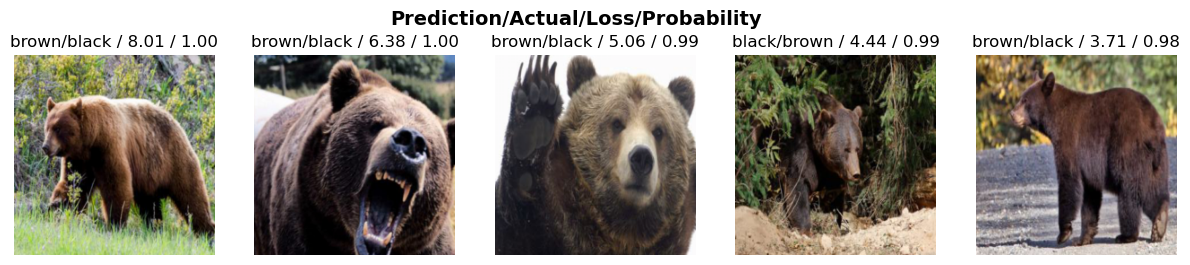

In [37]:
# Plot the top losses
interp.plot_top_losses(5,nrows=1)

In [38]:
from fastai.vision.widgets import *

In [46]:
# Cleaning the data
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: '/Users/adgb/fastai/fastai22/data/bears/teddy/ffd451c4-f1a9-4131-a456-114574f816fd.jpg'

In [45]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# Training

In [48]:
# Create new dls
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224,min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

In [49]:
# Train the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.484593,0.649879,0.228571,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.307283,0.204824,0.071429,00:11
1,0.283771,0.126845,0.028571,00:10
2,0.222556,0.143368,0.028571,00:10
3,0.180869,0.139916,0.028571,00:10
4,0.148773,0.152407,0.028571,00:11
5,0.122118,0.166727,0.028571,00:11
6,0.103061,0.175696,0.028571,00:11
7,0.090242,0.174561,0.028571,00:11
8,0.091874,0.176501,0.028571,00:11
9,0.082096,0.177023,0.028571,00:11


In [50]:
# Save the model
learn.export('models/bears_resnet18.pkl')

In [51]:
# Review the labels
learn.dls.vocab

['black', 'brown', 'teddy']